# ΔF/F Baseline Evaluation (Single-Plane Sweep)

This notebook keeps your original folder-selection & import style, evaluates **one plane** per experiment, sweeps **multiple percentiles and baseline windows**,  and writes a **baseline_sweep_summary** (top 50% most active cells → median peak & median σ).


At the end there's an **optional diagnostics** cell with simple baseline checks (baseline drift index and negative-side skewness).


In [2]:
# ==== Configuration (edit this) =================================================
from pathlib import Path
from datetime import datetime

# Base directory (same as your other notebook)
BASE_DIR = Path(r"C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p")

# Optional: limit to specific experiment folders (names)
EXPERIMENT_WHITELIST = [
    "L433_f02_Exp_1_flickering",
    "L453_f10_Exp_1_flickering",
    "L472_f03_Exp_2_rocking_1"
]

# Choose exactly one plane to evaluate (e.g., "plane0", "plane1", ...)
PLANE_TO_EVAL = "plane1"

# Imaging params (defaults; can be overridden per-experiment if you want)
FPS_DEFAULT = 2.0
TAU_DEFAULT = 6.0  # s, GCaMP6s ballpark

# Baseline / dF/F extraction parameters that we'll SWEEP
PERCENTILES = [5, 8, 10]                 # evaluate several percentiles
WINDOWS_S   = [10, 20, 40]          # evaluate several running windows (seconds)

# Other constants to pass through unchanged
INSTABILITY_RATIO = 0.1
MIN_STD = 0

# Where to save outputs from this evaluation
SESSION_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
EVAL_ROOT = BASE_DIR / f"baseline_eval_{SESSION_TS}"
EVAL_ROOT.mkdir(parents=True, exist_ok=True)

print("Configured.")

Configured.


In [3]:
# ==== Imports & helpers =========================================================
import sys, io, json, traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure your repo (that contains src/dff_extraction.py) is on sys.path if needed.
# Example:
# sys.path.append(r"C:\Users\suribear\code\dff_extraction_repo")

try:
    from src.dff_extraction import process_suite2p_fluorescence
except Exception as e:
    print("Could not import process_suite2p_fluorescence from src.dff_extraction.")
    raise

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def find_experiments(base_dir: Path, whitelist=None):
    """Return list of experiment directories that contain suite2P/plane* structure."""
    candidates = []
    for child in base_dir.iterdir():
        if not child.is_dir():
            continue
        if whitelist and child.name not in whitelist:
            continue
        s2p_root = child / "03_analysis" / "functional" / "suite2P"
        if s2p_root.exists() and any(p.is_dir() and p.name.startswith("plane") for p in s2p_root.iterdir()):
            candidates.append(child)
    return sorted(candidates, key=lambda p: p.name)

def plane_dir(exp_dir: Path, plane_name: str):
    s2p_root = exp_dir / "03_analysis" / "functional" / "suite2P"
    pdir = s2p_root / plane_name
    return pdir if pdir.exists() else None

def experiment_prefix(exp_name: str) -> str:
    parts = exp_name.split("_")
    if len(parts) >= 2:
        return parts[0] + "_" + parts[1]
    return exp_name

def estimate_sigma_negative_half(trace):
    """
    Robust σ estimate per ROI from the negative side of ΔF/F:
    - center to median
    - take values <= median (negative side)
    - MAD -> σ via 1.4826*MAD (Gaussian)
    """
    x = trace - np.median(trace)
    neg = x[x <= 0]
    if neg.size < 5:
        # fallback: overall MAD
        mad = np.median(np.abs(x - np.median(x)))
        return 1.4826 * mad if mad > 0 else np.std(x)
    mad = np.median(np.abs(neg - np.median(neg)))
    return 1.4826 * mad if mad > 0 else np.std(neg)

def plot_raster_gray(dFoF, vmax=0.4, title=None, save_path: Path=None):
    """
    dFoF: (T, N). Sort columns by each ROI's peak value (descending), then plot grayscale raster.
    """
    peaks = np.nanmax(dFoF, axis=0)
    order = np.argsort(-peaks)  # descending
    dplot = dFoF[:, order]

    plt.figure(figsize=(10, 5))
    plt.imshow(np.clip(dplot, 0, vmax).T, aspect='auto', cmap='gray_r', vmin=0, vmax=vmax, interpolation='nearest')
    plt.xlabel('Time (frames)')
    plt.ylabel('ROIs (sorted by peak)')
    if title:
        plt.title(title)
    plt.colorbar(label='ΔF/F (clipped @ {:.2f})'.format(vmax))
    plt.tight_layout()
    if save_path is not None:
        ensure_dir(save_path.parent)
        plt.savefig(save_path, dpi=200)
    plt.show()
    return order, peaks

print("Helpers ready.")

Helpers ready.


In [4]:
# ==== Find candidate experiments ===============================================
experiments = find_experiments(BASE_DIR, whitelist=EXPERIMENT_WHITELIST)
print(f"Found {len(experiments)} experiment folder(s).")
for e in experiments:
    print(" -", e.name)

if not experiments:
    raise RuntimeError("No experiments found. Check BASE_DIR or whitelist.")

# We'll process each selected experiment, but *only one plane* (PLANE_TO_EVAL).

Found 3 experiment folder(s).
 - L433_f02_Exp_1_flickering
 - L453_f10_Exp_1_flickering
 - L472_f03_Exp_2_rocking_1



=== L433_f02_Exp_1_flickering | plane1 | fps=2.0, tau=6.0 ===
  -> percentile= 5 | window=  10s ... Excluded 140 non-cell ROIs. Remaining: 441 cells.
Removed 0 dim ROIs.
Removed 0 unstable ROIs.
ΔF/F0 computed. Final ROIs: 441
Mean std: 0.01338 | min_std=0, z_event=3.0, min_event_frames=167 (= ceil(5.0% of 3340))
Removed 0 | Remaining: 441


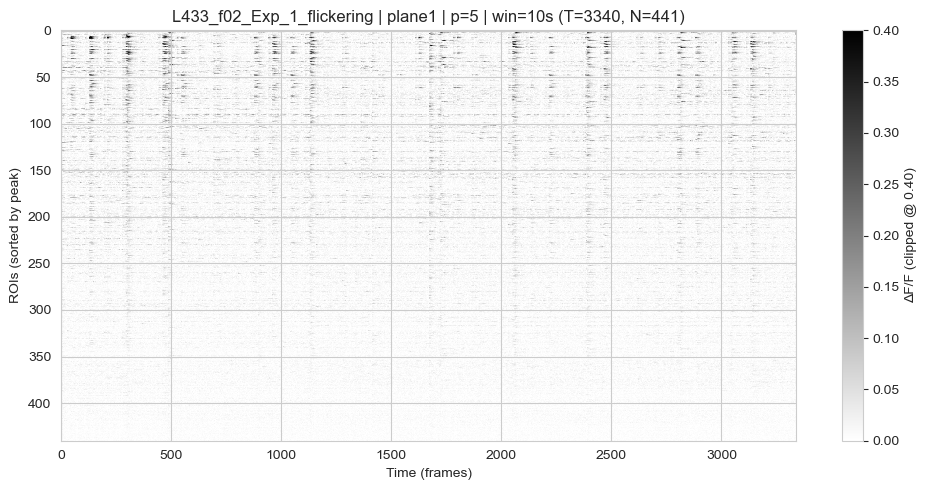

OK
  -> percentile= 5 | window=  20s ... Excluded 140 non-cell ROIs. Remaining: 441 cells.
Removed 0 dim ROIs.
Removed 0 unstable ROIs.
ΔF/F0 computed. Final ROIs: 441
Mean std: 0.01525 | min_std=0, z_event=3.0, min_event_frames=167 (= ceil(5.0% of 3340))
Removed 0 | Remaining: 441


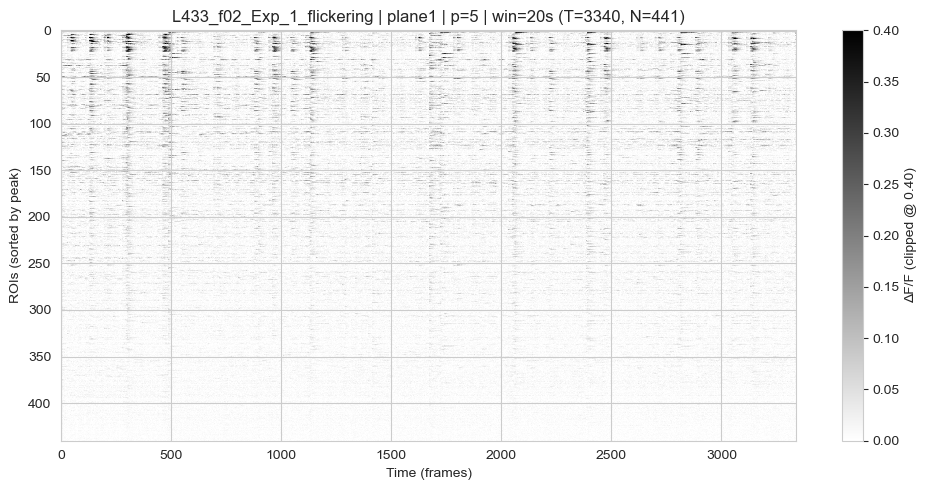

OK
  -> percentile= 5 | window=  40s ... Excluded 140 non-cell ROIs. Remaining: 441 cells.
Removed 0 dim ROIs.


In [ ]:
# ==== Evaluate baseline parameters on ONE plane per experiment ==================
all_rows = []   # rows for baseline_sweep_summary
failures = []

for exp_dir in experiments:
    exp_name = exp_dir.name
    exp_prefix = experiment_prefix(exp_name)

    pdir = plane_dir(exp_dir, PLANE_TO_EVAL)
    if pdir is None:
        print(f"[SKIP] {exp_name}: plane '{PLANE_TO_EVAL}' not found.")
        continue

    # Defaults (you can add per-experiment overrides if you like)
    fps = float(FPS_DEFAULT)
    tau = float(TAU_DEFAULT)

    print(f"\n=== {exp_name} | {PLANE_TO_EVAL} | fps={fps}, tau={tau} ===")
    out_base = EVAL_ROOT / exp_name / PLANE_TO_EVAL
    ensure_dir(out_base)

    for perc in PERCENTILES:
        for win_s in WINDOWS_S:
            try:
                # keep both min_window_s and window_tau_multiplier so 'win_s' drives behavior
                w_mult = max(1.0, win_s / tau)

                print(f"  -> percentile={perc:>2} | window={win_s:>4}s ... ", end="")
                dFoF, filtered_indices = process_suite2p_fluorescence(
                    f_path=pdir,
                    fps=fps,
                    tau=tau,
                    percentile=perc,
                    instability_ratio=INSTABILITY_RATIO,
                    min_window_s=win_s,
                    window_tau_multiplier=w_mult,
                    min_std=MIN_STD,
                )
                if not isinstance(dFoF, np.ndarray) or dFoF.ndim != 2:
                    raise ValueError("process_suite2p_fluorescence must return a (T,N) numpy array as first value")

                T, N = dFoF.shape

                # === Raster (grayscale, vmax=0.6) sorted by peak ===
                raster_png = out_base / f"{exp_prefix}_{PLANE_TO_EVAL}_raster_p{perc}_w{win_s}.png"
                title = f"{exp_name} | {PLANE_TO_EVAL} | p={perc} | win={win_s}s (T={T}, N={N})"
                order, peaks = plot_raster_gray(dFoF, vmax=0.4, title=title, save_path=raster_png)

                # === Baseline_sweep_summary (top 50% by activity) ===
                sel_count = max(1, N // 2)                   # top-half ROIs by peak ΔF/F
                sel_idx = np.argsort(-peaks)[:sel_count]
                median_peak = np.median(peaks[sel_idx])      # median peak among selected

                # per-ROI sigma (negative-side robust estimate)
                sigmas = np.array([estimate_sigma_negative_half(dFoF[:, i]) for i in range(N)])
                median_sigma = np.median(sigmas[sel_idx])

                all_rows.append({
                    "experiment": exp_name,
                    "plane": PLANE_TO_EVAL,
                    "percentile": perc,
                    "window_s": win_s,
                    "T": int(T),
                    "N": int(N),
                    "top50pct_n": int(sel_count),
                    "median_peak_top50": float(median_peak),
                    "median_sigma_top50": float(median_sigma),
                    "raster_path": str(raster_png),
                })
                print("OK")

                # save order & compact dFoF bundle for this combo
                np.save(out_base / f"{exp_prefix}_{PLANE_TO_EVAL}_order_p{perc}_w{win_s}.npy", order)
                np.savez_compressed(
                    out_base / f"{exp_prefix}_{PLANE_TO_EVAL}_dFoF_p{perc}_w{win_s}.npz",
                    dFoF=dFoF, filtered_indices=np.array(filtered_indices), order=order
                )

            except Exception as ex:
                print("ERROR")
                failures.append((exp_name, PLANE_TO_EVAL, perc, win_s, repr(ex)))
                traceback.print_exc()

# Write the summary CSV for all experiments/combos
if all_rows:
    df = pd.DataFrame(all_rows).sort_values(["experiment", "plane", "percentile", "window_s"])
    summary_csv = EVAL_ROOT / "baseline_sweep_summary.csv"
    df.to_csv(summary_csv, index=False, encoding="utf-8")
    print(f"\nSaved summary: {summary_csv}")
else:
    print("\nNo successful runs to summarize.")

if failures:
    print("\nFailures:")
    for f in failures:
        print("  ", f)

In [ ]:
# ==== Optional: extra baseline analysis cell ====================================
# Baseline diagnostics:
#   1) "Baseline drift index" per ROI (slow trend normalized by IQR).
#   2) Negative-side skewness (noise symmetry on negative ΔF/F).
# We report distributions for the "best" (percentile, window) according to
#     peak_over_sigma = median_peak_top50 / median_sigma_top50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def baseline_drift_index(trace, window=301):
    """
    Simple drift index: slope of a coarse moving average (frames) normalized by IQR.
    window is in frames; make it odd.
    """
    w = int(window) if int(window) % 2 == 1 else int(window) + 1
    if w < 11: w = 11
    pad = w // 2
    x = np.pad(trace, (pad, pad), mode='edge')
    mov = np.convolve(x, np.ones(w)/w, mode='valid')  # fast proxy for slow trend
    t = np.arange(mov.size)
    A = np.vstack([t, np.ones_like(t)]).T
    m, b = np.linalg.lstsq(A, mov, rcond=None)[0]
    iqr = np.subtract(*np.percentile(trace, [75, 25]))
    return m / (iqr + 1e-9)

def neg_side_skewness(trace):
    x = trace - np.median(trace)
    neg = x[x <= 0]
    if neg.size < 8:
        return np.nan
    m = np.mean(neg)
    s = np.std(neg) + 1e-9
    skew = np.mean(((neg - m)/s)**3)
    return skew

# Load summary and pick best combo
summary_path = EVAL_ROOT / "baseline_sweep_summary.csv"
if not summary_path.exists():
    raise RuntimeError(f"Summary CSV not found: {summary_path}")

df = pd.read_csv(summary_path)
df["peak_over_sigma"] = df["median_peak_top50"] / (df["median_sigma_top50"] + 1e-12)
best = df.sort_values("peak_over_sigma", ascending=False).iloc[0]
print("Best combo by peak/σ:", dict(best))

# Load the corresponding dFoF bundle
bundle_path = Path(best["raster_path"]).with_name(
    Path(best["raster_path"]).name.replace("_raster_", "_dFoF_").replace(".png", ".npz")
)
if not bundle_path.exists():
    raise RuntimeError(f"dFoF bundle not found: {bundle_path}")

bundle = np.load(bundle_path)
dFoF = bundle["dFoF"]  # (T,N)

# Compute indices per ROI
window_for_drift_frames = int(60 * FPS_DEFAULT)  # ~60 s window at FPS_DEFAULT
drifts = np.array([baseline_drift_index(dFoF[:, i], window=window_for_drift_frames) for i in range(dFoF.shape[1])])
skews  = np.array([neg_side_skewness(dFoF[:, i]) for i in range(dFoF.shape[1])])

# Plots
plt.figure(figsize=(10,4))
plt.hist(drifts[np.isfinite(drifts)], bins=60)
plt.title("Baseline drift index (slope/IQR) across ROIs")
plt.xlabel("drift index (≈0 is stable)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(skews[np.isfinite(skews)], bins=60)
plt.title("Negative-side skewness across ROIs")
plt.xlabel("skewness (≈0 is symmetric noise)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Save CSV for these diagnostics
diag = pd.DataFrame({"drift_index": drifts, "neg_side_skewness": skews})
diag_csv = Path(best["raster_path"]).with_name("baseline_diagnostics_perROI.csv")
diag.to_csv(diag_csv, index=False)
print(f"Saved per-ROI diagnostics: {diag_csv}")